In [1]:
!pip install transformers torch bitsandbytes accelerate datasets peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 29.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 526.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 76.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━

### Model Information

**Model Card:** https://huggingface.co/HuggingFaceM4/idefics2-8b

**Fine-tuning Instructions:** https://colab.research.google.com/drive/1NtcTgRbSBKN7pYD3Vdx1j9m8pt3fhFDB?usp=sharing#scrollTo=SMujNa2vKbZd

In [2]:
# Load model directly
from transformers import AutoProcessor, AutoModelForPreTraining, BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b")
model = AutoModelForPreTraining.from_pretrained("HuggingFaceM4/idefics2-8b",
                                                torch_dtype=torch.float16,
                                                quantization_config=bnb_config,
                                                device_map="cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.
Loading checkpoint shards: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


In [6]:
gbs = model.get_memory_footprint() / 1e9

print(f"Number of parameters: {model.num_parameters()}")
print(f"Memory footpring if FP32: {(model.num_parameters()*4)/1e9} GB")
print(f"Memory footprint of the model with 4bit quantization: {gbs:.2f} GB")

Number of parameters: 8402768112
Memory footpring if FP32: 33.611072448 GB
Memory footprint of the model with 4bit quantization: 4.61 GB


### Load in Images

In [10]:
from transformers.image_utils import load_image

image1 = load_image("content/bird walking on grass.jpeg")
image2 = load_image("content/cat sitting on table.jpeg")

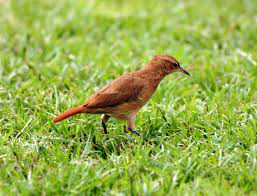

In [11]:
image1

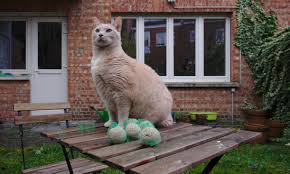

In [12]:
image2

### Generating Captions

In [13]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# Create inputs
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What do we see in this image?"},
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "A small brown bird standing on top of a lush green field."},
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "And how about this image?"},
        ]
    },
]
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image1, image2], return_tensors="pt")
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

In [14]:
# To see how the messages are formatted after applying chat template
print(prompt)

User:<image>What do we see in this image?<end_of_utterance>
Assistant: A small brown bird standing on top of a lush green field.<end_of_utterance>
User:<image>And how about this image?<end_of_utterance>
Assistant:


In [15]:
# Generate
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

In [16]:
for text in generated_texts:
    print(text)

User: What do we see in this image? 
Assistant: A small brown bird standing on top of a lush green field. 
User: And how about this image? 
Assistant: A cat is sitting on a table in front of a brick house.


### Fine-Tuning Our Image --> Text Model

If you have a higher tier subscription to google colab or more compute power than the free tier, you can try fine-tuning this model to perform on the following image QA task.

#### Load Dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("derek-thomas/ScienceQA")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 12726
    })
    validation: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 4241
    })
    test: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 4241
    })
})

In [ ]:
dataset['test'][17]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=518x80>,
 'question': 'Think about the magnetic force between the magnets in each pair. Which of the following statements is true?',
 'choices': ['The magnetic force is stronger in Pair 2.',
  'The magnetic force is stronger in Pair 1.',
  'The strength of the magnetic force is the same in both pairs.'],
 'answer': 1,
 'hint': 'The images below show two pairs of magnets. The magnets in different pairs do not affect each other. All the magnets shown are made of the same material.',
 'task': 'closed choice',
 'grade': 'grade4',
 'subject': 'natural science',
 'topic': 'physics',
 'category': 'Magnets',
 'skill': 'Compare strengths of magnetic forces',
 'lecture': 'Magnets can pull or push on each other without touching. When magnets attract, they pull together. When magnets repel, they push apart.\nThese pulls and pushes between magnets are called magnetic forces. The stronger the magnetic force between two magnets, the more 

#### Test model on image

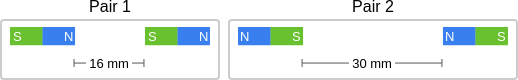

In [ ]:
idx = 17
image = dataset['test'][idx]['image']
image

In [ ]:
def format_question(example):
    question = example['question']

    for choice in example['choices']:
        question += f"\n{choice}"

    return question

def format_answer(example):
    answer = example['choices'][example['answer']]
    return answer

question = format_question(dataset['test'][idx])
answer = format_answer(dataset['test'][idx])

print("Question: ", question)
print("Answer: ", answer)

Question:  Think about the magnetic force between the magnets in each pair. Which of the following statements is true?
The magnetic force is stronger in Pair 2.
The magnetic force is stronger in Pair 1.
The strength of the magnetic force is the same in both pairs.
Answer:  The magnetic force is stronger in Pair 1.


In [ ]:
def generate_response(image, question):
  # Create inputs
  messages = [
      {
          "role": "user",
          "content": [
              {"type": "image"},
              {"type": "text", "text": question},
          ]
      }
          ]
  prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
  inputs = processor(text=prompt, images=[image], return_tensors="pt")
  inputs = {k: v for k, v in inputs.items()}


  # Generate
  generated_ids = model.generate(**inputs, max_new_tokens=500)
  generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

  response = generated_texts[-1].split('\n')[-1]
  return response

generate_response(image, question)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1659: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


'Assistant: The strength of the magnetic force is the same in both pairs.'

#### Prepare Dataset for Training

In [ ]:
# 1. Remove non-image examples
dataset = dataset.filter(lambda x: x['image'] is not None)

# 2. Shuffle and select first 1000 examples in train, eval
dataset['train'] = dataset['train'].shuffle().select(range(500))
dataset['validation'] = dataset['validation'].shuffle().select(range(500))

# 3. Format dataset
dataset = dataset.map(lambda x: {'image': x['image'], 'question': format_question(x), 'answer': format_answer(x)})

# 4. Remove unnecessary columns
dataset = dataset.remove_columns(['choices', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'])

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
train_dataset = dataset['train']
eval_dataset = dataset['validation']

In [ ]:
train_dataset

Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 500
})

In [ ]:
import random

class MyDataCollator:
    def __init__(self, processor):
        self.processor = processor
        self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")
        ]

    def __call__(self, examples):
        texts = []
        images = []
        for example in examples:
            image = example["image"]
            question = example["question"]
            answer = example["answer"]
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]
            text = processor.apply_chat_template(messages, add_generation_prompt=False)
            texts.append(text.strip())
            images.append([image])

        batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

        labels = batch["input_ids"].clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.image_token_id
        batch["labels"] = labels

        return batch

data_collator = MyDataCollator(processor)

#### Prepare Model QLora Training

In [ ]:
from peft import LoraConfig


lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
        use_dora=False,
        init_lora_weights="gaussian"
)

model.add_adapter(lora_config)
model.enable_adapters()

#### Train Model on Dataset

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    output_dir="./train_output",
    save_strategy="steps",
    save_steps=250,
    save_total_limit=1,
    # evaluation_strategy="epoch",
    fp16=True,
    push_to_hub_model_id="ingeniumacademy/image-qa-8b",
    remove_unused_columns=False,
    report_to="none",
    no_cuda=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    # eval_dataset=eval_dataset, # You can also evaluate (loss) on the eval set, note that it will incur some additional GPU memory
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1984: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case ingeniumacademy/ingeniumacademy/image-qa-8b).
  warnings.warn(


In [ ]:
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 112.00 MiB. GPU 